In [1]:
import logging
import os.path

import matplotlib.pyplot as plt
import networkx as nx
import pygtfs

from itertools import product
from sqlalchemy.orm import joinedload

logging.basicConfig()
logging.getLogger('sqlalchemy.engine').setLevel(logging.WARN)

In [2]:
# Use a local database to store the schedues in
sched = pygtfs.Schedule("paris_full.sqlite")

In [92]:
# Import the metro lines into the database
#pygtfs.append_feed(sched, os.path.join("RATP_GTFS_LINES", "RATP_GTFS_METRO_7.zip"))
pygtfs.append_feed(sched, "RATP_GTFS_FULL.zip")

Loading GTFS data for <class 'pygtfs.gtfs_entities.Agency'>:
Loading GTFS data for <class 'pygtfs.gtfs_entities.Stop'>:
Loading GTFS data for <class 'pygtfs.gtfs_entities.Route'>:
Loading GTFS data for <class 'pygtfs.gtfs_entities.Trip'>:
Loading GTFS data for <class 'pygtfs.gtfs_entities.StopTime'>:
Loading GTFS data for <class 'pygtfs.gtfs_entities.Service'>:
Loading GTFS data for <class 'pygtfs.gtfs_entities.ServiceException'>:
Loading GTFS data for <class 'pygtfs.gtfs_entities.Fare'>:
Loading GTFS data for <class 'pygtfs.gtfs_entities.FareRule'>:
Loading GTFS data for <class 'pygtfs.gtfs_entities.ShapePoint'>:
Loading GTFS data for <class 'pygtfs.gtfs_entities.Frequency'>:
Loading GTFS data for <class 'pygtfs.gtfs_entities.Transfer'>:
Loading GTFS data for <class 'pygtfs.gtfs_entities.FeedInfo'>:
Loading GTFS data for <class 'pygtfs.gtfs_entities.Translation'>:
1 record read for <class 'pygtfs.gtfs_entities.Agency'>.
.....25806 records read for <class 'pygtfs.gtfs_entities.Stop'>.


In [4]:
# Get out home stop to root the tree at
root_stop = next(s for s in sched.stops if s.stop_name == "Place Monge (Jardin des Plantes)")

c:\users\james\.virtualenvs\data_visualizations-iibv-upr\lib\site-packages\sqlalchemy\orm\relationships.py:2725: SAWarning: relationship 'Route.agency' will copy column agency.feed_id to column routes.feed_id, which conflicts with relationship(s): 'Route.feed' (copies _feed.feed_id to routes.feed_id). Consider applying viewonly=True to read-only relationships, or provide a primaryjoin condition marking writable columns with the foreign() annotation.
  for (pr, fr_) in other_props)
c:\users\james\.virtualenvs\data_visualizations-iibv-upr\lib\site-packages\sqlalchemy\orm\relationships.py:2725: SAWarning: relationship 'StopTime.stop' will copy column stops.feed_id to column stop_times.feed_id, which conflicts with relationship(s): 'StopTime.feed' (copies _feed.feed_id to stop_times.feed_id). Consider applying viewonly=True to read-only relationships, or provide a primaryjoin condition marking writable columns with the foreign() annotation.
  for (pr, fr_) in other_props)
c:\users\james\.v

In [10]:
print(root_stop.__dict__)
[t.stop_to.__dict__ for t in root_stop.transfers_from[1].stop_to.transfers_to]

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x0000020C744F55C0>, 'feed_id': 1, 'wheelchair_boarding': None, 'parent_station': '', 'stop_url': None, 'zone_id': None, 'stop_name': 'Place Monge (Jardin des Plantes)', 'stop_id': '1649', 'stop_lat': 48.843164692766834, 'platform_code': None, 'stop_timezone': None, 'location_type': 0, 'stop_lon': 2.3521103624150967, 'stop_desc': 'Arènes de Lutèce - 75105', 'stop_code': ''}


[{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x20c7343b048>,
  'feed_id': 1,
  'location_type': 0,
  'parent_station': '',
  'platform_code': None,
  'stop_code': '',
  'stop_desc': '77 BIS RUE MONGE - 75105',
  'stop_id': '4036778',
  'stop_lat': 48.84288605707058,
  'stop_lon': 2.352287297121382,
  'stop_name': 'MONGE',
  'stop_timezone': None,
  'stop_url': None,
  'transfers_to': [<Transfer 1649-4036778>,
   <Transfer 2529-4036778>,
   <Transfer 5018346-4036778>,
   <Transfer 5018405-4036778>,
   <Transfer 6251754-4036778>],
  'wheelchair_boarding': None,
  'zone_id': None},
 {'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x20c7343b048>,
  'feed_id': 1,
  'location_type': 0,
  'parent_station': '',
  'platform_code': None,
  'stop_code': '',
  'stop_desc': '77 BIS RUE MONGE - 75105',
  'stop_id': '4036778',
  'stop_lat': 48.84288605707058,
  'stop_lon': 2.352287297121382,
  'stop_name': 'MONGE',
  'stop_timezone': None,
  'stop_url': None,
  'transf

In [3]:
# We only care about metro and RER routes
rail_routes = [r for r in sched.routes if r.route_type in [1, 2]]

c:\users\james\.virtualenvs\data_visualizations-iibv-upr\lib\site-packages\sqlalchemy\orm\relationships.py:2725: SAWarning: relationship 'Route.agency' will copy column agency.feed_id to column routes.feed_id, which conflicts with relationship(s): 'Route.feed' (copies _feed.feed_id to routes.feed_id). Consider applying viewonly=True to read-only relationships, or provide a primaryjoin condition marking writable columns with the foreign() annotation.
  for (pr, fr_) in other_props)
c:\users\james\.virtualenvs\data_visualizations-iibv-upr\lib\site-packages\sqlalchemy\orm\relationships.py:2725: SAWarning: relationship 'StopTime.stop' will copy column stops.feed_id to column stop_times.feed_id, which conflicts with relationship(s): 'StopTime.feed' (copies _feed.feed_id to stop_times.feed_id). Consider applying viewonly=True to read-only relationships, or provide a primaryjoin condition marking writable columns with the foreign() annotation.
  for (pr, fr_) in other_props)
c:\users\james\.v

In [4]:
def longest_extent(route):
    """ Given a route, analyse its trips to find the longest one """
    trips = (sched.session.query(pygtfs.gtfs_entities.Trip)
             .filter(pygtfs.gtfs_entities.Trip.route_id == route.id)
             .options(joinedload('stop_times')).all())
    longest_trip = trips[0]
    trip_length = len(longest_trip.stop_times)
    
    for trip in trips[1:]:
        if len(trip.stop_times) > trip_length:
            print("Found a longer trip")
            longest_trip = trip
            trip_length = len(trip.stop_times)

    return longest_trip


def print_route_info(routes):
    """ Debug function to print route information """
    for route in routes:
        longest_trip = longest_extent(route)
        # The pygtfs module doesn't return stops in order for some reason - maybe
        # they are like that in the dataset
        stop_times = sorted(longest_trip.stop_times, key=lambda s: s.departure_time)
        start = stop_times[0].stop
        end = stop_times[-1].stop
        print("{}: {} -> {} ({} stops)".format(route, start, end, len(stop_times)))
        
        # Manually delete the longest trip to ensure we don't start eating memory
        del longest_trip

#print_route_info(rail_routes)

In [5]:
# Translate the line into a directed graph. Each node of
# the graph should represent a logical train station
# and should contain all the stops in that station
#
# Each edge of the graph should represent a journey
# on a line, and contain info about the journey time
# and the route it is from
G = nx.MultiDiGraph()

for route in rail_routes:
    l_trip = longest_extent(route)
    stop_times = sorted(l_trip.stop_times,
                        key=lambda t: t.departure_time)
    for start, end in zip(stop_times[:-1], 
                          stop_times[1:]):
        journey_time = (end.arrival_time - start.departure_time).total_seconds()
        # print("Add edge from {} to {}"
        #       .format(start.stop.stop_name,
        #               end.stop.stop_name))
        G.add_edge(start.stop,
                   end.stop,
                   colour=route.route_color,
                   journey_time=journey_time)
    del l_trip

# Add edges to represent transfers between different platforms in the same station
for node_a, node_b in product(G.nodes(), G.nodes()):
    if node_a.stop_name == node_b.stop_name:
        G.add_edge(node_a,
                   node_b,
                   journey_time=20)

Found a longer trip
Found a longer trip
Found a longer trip
Found a longer trip
Found a longer trip
Found a longer trip
Found a longer trip
Found a longer trip
Found a longer trip
Found a longer trip
Found a longer trip
Found a longer trip


Base graph has 945 nodes and 4257 edges
{0.0, 420.0, 360.0, 300.0, 240.0, 180.0, 20, 120.0, 60.0}


(array([2898.,    0.,  549.,    0.,    0.,  514.,    0.,    0.,  186.,
           0.,    0.,   79.,    0.,    0.,   17.,    0.,    0.,   10.,
           0.,    4.]),
 array([  0.,  21.,  42.,  63.,  84., 105., 126., 147., 168., 189., 210.,
        231., 252., 273., 294., 315., 336., 357., 378., 399., 420.]),
 <a list of 20 Patch objects>)

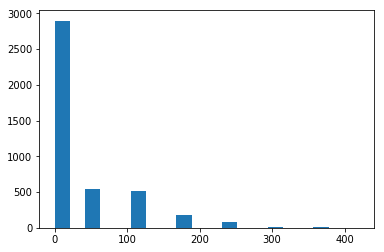

In [6]:
print("Base graph has {} nodes and {} edges"
      .format(len(G.nodes()), len(G.edges())))

journey_times = [d['journey_time'] for _, _, d in G.edges.data()]
print(set(journey_times))

plt.hist(journey_times, bins=20)

In [7]:
T = nx.minimum_spanning_arborescence(G, attr='journey_time')
print("Spanning tree has {} nodes and {} edges"
      .format(len(T.nodes()), len(T.edges())))

Spanning tree has 945 nodes and 944 edges


In [8]:
# Contract down the graph so merge all the stops for a given station
# into one
#
# Doing this will move the edge properties into a subdictionry in the
# event that there would have been multiple edges between the merged
# components
same_station = lambda u, v: u.stop_name == v.stop_name

Q = nx.quotient_graph(T, same_station)
Q.remove_edges_from([(n, n) for n in Q.nodes()])

print("Quotient graph has {} nodes and {} edges"
      .format(len(Q.nodes()), len(Q.edges())))

Quotient graph has 388 nodes and 388 edges


In [14]:
def draw_network(graph):
    elarge = [(u, v) for (u, v, d) in graph.edges(data=True) if d[0]['journey_time'] > 300]
    esmall = [(u, v) for (u, v, d) in graph.edges(data=True) if d[0]['journey_time'] <= 300]

    pos = nx.spring_layout(graph)  # positions for all nodes

    # nodes
    nx.draw_networkx_nodes(graph, pos, node_size=10)

    # edges
    nx.draw_networkx_edges(graph, pos, edgelist=elarge,
                           width=6)
    nx.draw_networkx_edges(graph, pos, edgelist=esmall,
                           width=6, alpha=0.5, edge_color='b', style='dashed')

    # labels
    #nx.draw_networkx_labels(graph, pos, font_size=10, font_family='sans-serif')

    plt.axis('off')
    plt.show()

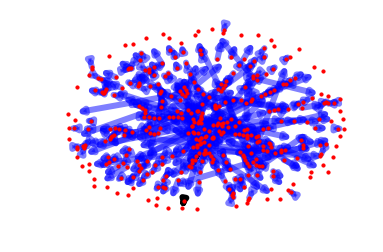

In [15]:
draw_network(Q)

In [9]:
def draw_geographic_network(graph):
    fig = plt.figure(figsize=(12,12))
    axes = fig.add_subplot(111)

    x, y = zip(*[(s.stop_lat, s.stop_lon) for s in graph.nodes()])
    axes.plot(x, y, 'ro')
    
    for start, end in graph.edges():
        axes.plot([start.stop_lat, end.stop_lat],
                  [start.stop_lon, end.stop_lon],
                  'b-')

def draw_geographic_quotient_network(graph):
    # Plot the graph for the first stop in every set
    fig = plt.figure(figsize=(12,12))
    axes = fig.add_subplot(111)

    stops = [list(s)[0] for s in graph.nodes()]
    x, y = zip(*[(s.stop_lat, s.stop_lon) for s in stops])
    axes.plot(x, y, 'ro')
    
    for start_set, end_set in graph.edges():
        start = list(start_set)[0]
        end = list(end_set)[0]
        axes.plot([start.stop_lat, end.stop_lat],
                  [start.stop_lon, end.stop_lon],
                  'b-')

def draw_gridded_quotient_network(graph):
    # Map the geographic locations of the stops onto a
    # regular grid. Ideas:
    # -  Use numpy to work out a set of 2d grid bins that would
    #    have at most one stop per bin and then use bin numbers
    #    as  grid points
    # -  Hexagonal binning. Either create uniform sized hexagons around
    #    each station and then collide them together somehow or overlay
    #    a hexagonal grid until there is at most one stop in each bin.
    #    Take a note of which sides have lines going through them

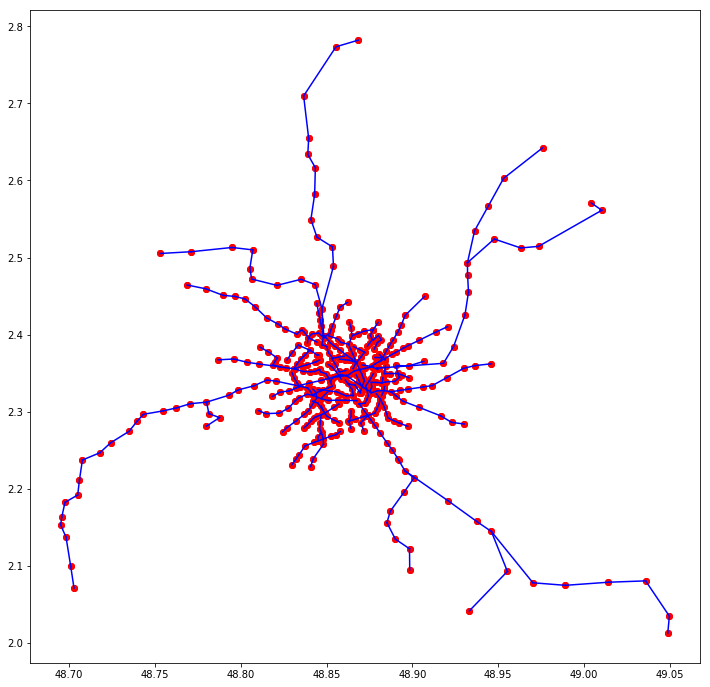

In [17]:
draw_geographic_network(T)

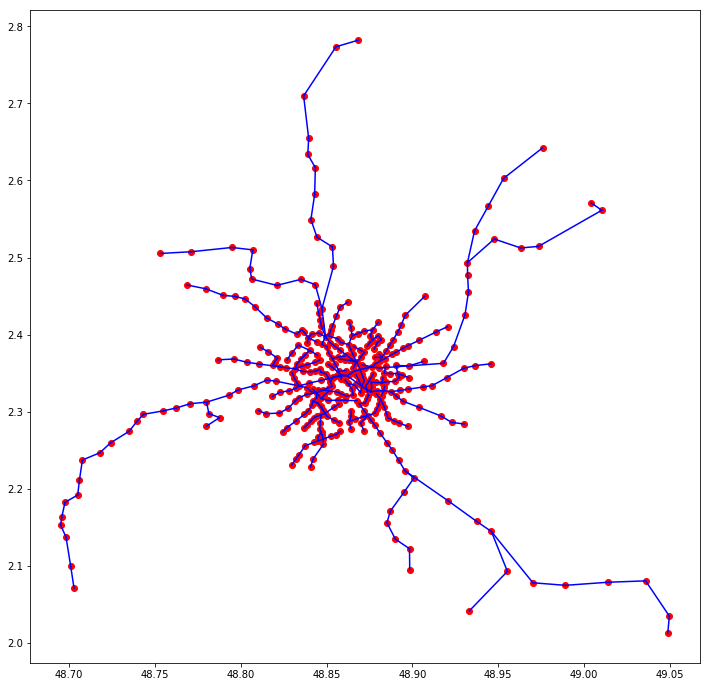

In [10]:
draw_geographic_quotient_network(Q)